In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mping
import seaborn as sns   #数据可视化
%matplotlib inline
np.random.seed(2) #生成相同的随机数据

In [40]:
#分割数据集为训练集和测试集
from sklearn.model_selection import train_test_split 
#混合矩阵（真正例、真负例，。。），用以评价机器学习算法的效果，精度等
from sklearn.metrics import confusion_matrix 
import itertools    #用于操作迭代对象的函数
#将整型标签转为onehot
#to_categorical就是将类别向量转换为二进制（只有0和1）的矩阵类型表示。
#其表现为将原有的类别向量转换为独热编码的形式
from keras.utils.np_utils import to_categorical # convert to one-hot-eccoding
#顺序模型是多个网络层的线性堆叠
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
#用以生成一个batch的图像数据，支持实时数据提升。
#训练时该函数会无限生成数据，直到达到规定的epoch次数为止
from keras.preprocessing.image import ImageDataGenerator
#当评价指标不在提升时，减少学习率
from keras.callbacks import ReduceLROnPlateau

#seaborn中style用于设置主题
#set_context
#set the matplotlib parameters to scale plot elements
#axes_style
#return a dict of parameters defining a figure style
#color_palette
#define the color palette for a plot
sns.set(style="white",context="notebook",palette="deep")

In [41]:
#load the data,其中test数据集中没有标签
train = pd.read_csv("C:/Users/hh/Desktop/Kaggle/1.0 Digital Recognizer/data/train.csv")
test = pd.read_csv("C:/Users/hh/Desktop/Kaggle/1.0 Digital Recognizer/data/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

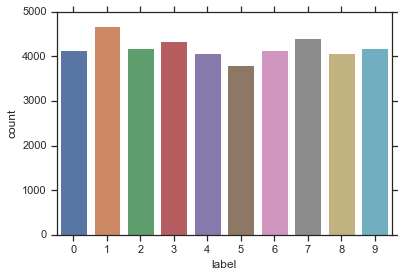

In [42]:
Y_train = train["label"]
#Drop "label" column
X_train = train.drop(labels = ["label"],axis = 1)
#free some space
del train

g = sns.countplot(Y_train)
Y_train.value_counts()

In [43]:
#check the data,统计data里每一列是否有空值
#isnull是所有空数据，any是进行与运算，describe其实是用来查看第一个数据是什么的
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [44]:
#check for corrupted images (missing values inside).
#There is no missing values in the train and test dataset. So we can safely go ahead
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [45]:
# Normalize the data
X_train = X_train / 255.0
test = test /255.0

In [46]:
#将784维的数据转换为28*28*1的3 dimensional格式
## Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
#参数-1代表新数组的shape属性应该要与原来数组的一致，即新数组元素数量与原数组元素数量要相等
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [48]:
#encode labels to one hot vectors
#Labels are 10 digits numbers from 0 to 9. 
#We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).
Y_train = to_categorical(Y_train,num_classes = 10)

In [49]:
#set the random seed
random_seed = 2

In [50]:
# split the train and the validation set for the fitting
# split the train set in two parts : 
# a small fraction (10%) became the validation set which the model is evaluated 
# and the rest (90%) is used to train the model


# Since we have 42 000 training images of balanced labels (see 2.1 Load data), 
# a random split of the train set doesn't cause some labels to be over represented
# in the validation set. Be carefull with some unbalanced dataset a simple random split 
# could cause inaccurate evaluation during the validation
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size = 0.1,
                                              random_state=random_seed)

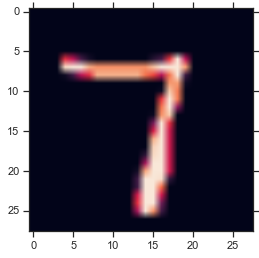

In [63]:
# show some examples
#查看当前样本的形态
g = plt.imshow(X_train[1][:,:,0])

In [73]:
# set cnn model
#the cnn architecture is IN -> [[cONV3d->RELU] * 2 -> MaxPool2D -> Dropout] * 2 ->Flatten
# -> Dense ->Dropout -> out
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = "Same",
                    activation = "relu",input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = "Same",activation = "relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "Same",activation = "relu"))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "Same",activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256,activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(10,activation = "softmax"))

In [76]:
# define the optimizer
optimizer = RMSprop(lr = 0.001, rho = 0.9, epsilon = 1e-08,decay = 0.0)

In [77]:
# compile the model
model.compile(optimizer = optimizer, loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [81]:
# 使用学习率衰减，reduce the LR by half if the accuracy is not improved after 3 epochs
# set a learning rate annealer
# monitor：被监测的量
# factor：每次减少学习率的因子，学习率将以lr = lr*factor的形式被减少
# patience：当patience个epoch过去而模型性能不提升时，学习率减少的动作会被触发
# mode：‘auto’，‘min’，‘max’之一，在min模式下，如果检测值触发学习率减少。
# 在max模式下，当检测值不再上升则触发学习率减少。
# epsilon：阈值，用来确定是否进入检测值的“平原区”
# cooldown：学习率减少后，会经过cooldown个epoch才重新进行正常操作
# min_lr：学习率的下限
# verbose：日志显示
# verbose = 0 为不在标准输出流输出日志信息
# verbose = 1 为输出进度条记录
# verbose = 2 为每个epoch输出一行记录
# 注意： 默认为 1
learning_rate_reduction = ReduceLROnPlateau(monitor = "val_acc",patience = 3, 
                                            verbose = 1, factor = 0.5, min_lr = 0.00001)

In [122]:
# Turn epochs to 30 to get 0.9967
epochs = 30
batch_size = 86

In [123]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#validation_data = (X_val, Y_val), verbose = 2)

In [124]:
# with data augmentation to prevent overfitting(accuracy 0.99286)
# featurewise_center：布尔值，使输入数据集去中心化（均值为0）, 按feature执行。
# samplewise_center：布尔值，使输入数据的每个样本均值为0。
# featurewise_std_normalization：布尔值，将输入除以数据集的标准差以完成标准化, 
#                               按feature执行。
# samplewise_std_normalization：布尔值，将输入的每个样本除以其自身的标准差。
# zca_whitening：布尔值，对输入数据施加ZCA白化。
# rotation_range：整数，数据提升时图片随机转动的角度。随机选择图片的角度，
#                 是一个0~180的度数，取值为0~180。
# width_shift_range：浮点数，图片宽度的某个比例，数据提升时图片随机水平偏移的幅度。
# height_shift_range：浮点数，图片高度的某个比例，数据提升时图片随机竖直偏移的幅度。 
# height_shift_range和width_shift_range是用来指定水平和竖直方向随机移动的程度，
#                                       这是两个0~1之间的比例。
# shear_range：浮点数，剪切强度（逆时针方向的剪切变换角度）。是用来进行剪切变换的程度。
# zoom_range：浮点数或形如[lower,upper]的列表，随机缩放的幅度，若为浮点数，
#             则相当于[lower,upper] = [1 - zoom_range, 1+zoom_range]。用来进行随机的放大。
# channel_shift_range：浮点数，随机通道偏移的幅度。
# fill_mode：‘constant’，‘nearest’，‘reflect’或‘wrap’之一，
#           当进行变换时超出边界的点将根据本参数给定的方法进行处理
# cval：浮点数或整数，当fill_mode=constant时，指定要向超出边界的点填充的值。
# horizontal_flip：布尔值，进行随机水平翻转。随机的对图片进行水平翻转，
#                 这个参数适用于水平翻转不影响图片语义的时候。
# vertical_flip：布尔值，进行随机竖直翻转。
# rescale: 值将在执行其他处理前乘到整个图像上，我们的图像在RGB通道都是0~255的整数，
#          这样的操作可能使图像的值过高或过低，所以我们将这个值定为0~1之间的数。
# preprocessing_function: 将被应用于每个输入的函数。该函数将在任何其他修改之前运行。
#                         该函数接受一个参数，为一张图片（秩为3的numpy array），
#                         并且输出一个具有相同shape的numpy array
# data_format：字符串，“channel_first”或“channel_last”之一，
#             代表图像的通道维的位置。该参数是Keras 1.x中的image_dim_ordering，
#              “channel_last”对应原本的“tf”，“channel_first”对应原本的“th”。
#              以128x128的RGB图像为例，“channel_first”应将数据组织为（3,128,128），
#              而“channel_last”应将数据组织为（128,128,3）。
#              该参数的默认值是~/.keras/keras.json中设置的值，若从未设置过，
#              则为“channel_last”
datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center = False,
                            featurewise_std_normalization = False,
                            samplewise_std_normalization = False,
                            zca_whitening = False,
                            rotation_range = 0.1,
                            zoom_range = 0.1,
                            width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            horizontal_flip = False,
                            vertical_flip = False)
datagen.fit(X_train)

In [125]:
# Fit the model
# 回调函数Callbacks，回调函数是一组在训练的特定阶段被调用的函数集，
#你可以使用回调函数来观察训练过程中网络内部的状态和统计信息。
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = batch_size),
                             epochs = epochs, validation_data = (X_val,Y_val),
                             verbose = 2, steps_per_epoch = X_train.shape[0]//batch_size,
                             callbacks = [learning_rate_reduction])

Epoch 1/30
 - 178s - loss: 0.0509 - acc: 0.9848 - val_loss: 0.0218 - val_acc: 0.9926
Epoch 2/30
 - 177s - loss: 0.0508 - acc: 0.9851 - val_loss: 0.0205 - val_acc: 0.9929
Epoch 3/30
 - 179s - loss: 0.0466 - acc: 0.9867 - val_loss: 0.0231 - val_acc: 0.9948
Epoch 4/30
 - 178s - loss: 0.0433 - acc: 0.9879 - val_loss: 0.0316 - val_acc: 0.9912
Epoch 5/30
 - 178s - loss: 0.0436 - acc: 0.9874 - val_loss: 0.0249 - val_acc: 0.9936
Epoch 6/30
 - 178s - loss: 0.0430 - acc: 0.9879 - val_loss: 0.0220 - val_acc: 0.9931

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/30
 - 177s - loss: 0.0334 - acc: 0.9900 - val_loss: 0.0236 - val_acc: 0.9931
Epoch 8/30
 - 177s - loss: 0.0304 - acc: 0.9916 - val_loss: 0.0181 - val_acc: 0.9957
Epoch 9/30
 - 177s - loss: 0.0308 - acc: 0.9916 - val_loss: 0.0180 - val_acc: 0.9948
Epoch 10/30
 - 189s - loss: 0.0280 - acc: 0.9919 - val_loss: 0.0226 - val_acc: 0.9945
Epoch 11/30
 - 197s - loss: 0.0288 - acc: 0.9915 - val_loss: 0.0194 

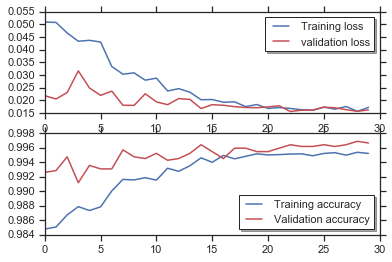

In [126]:
# plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history["loss"],color = "b", label = "Training loss")
ax[0].plot(history.history["val_loss"],color = "r",label = "validation loss",axes = ax[0])
legend = ax[0].legend(loc = "best",shadow = True)
ax[1].plot(history.history["acc"],color = "b", label = "Training accuracy")
ax[1].plot(history.history["val_acc"],color = "r",label = "Validation accuracy")
legend = ax[1].legend(loc = "best",shadow = True)

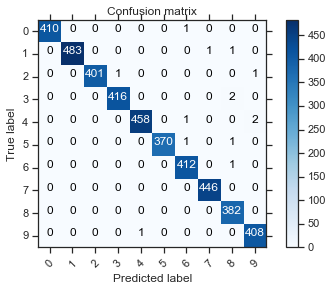

In [127]:
# Look at confusion matrix
def plot_confusion_matrix(cm,classes, normalize = False, title = "Confusion matrix",
                         cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype("float")/cm.sum(asix = 1)[:,np.newaxis]
    thresh = cm.max() / 2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment = "center", 
                color = "white" if cm[i,j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observation to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

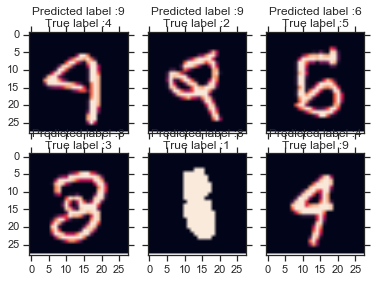

In [128]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [129]:
# predict results
results = model.predict(test)
# select the indix with the maximum probability
results = np.argmax(results, axis = 1)
results = pd.Series(results,name = "Label")

In [130]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("cnn_mnist_datagen.csv",index = False)

In [131]:
# link         https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/data